In [57]:
import numpy as np
import librosa
from multiprocessing import Pool
import pandas as pd
import psutil
import os
import threading
import time
import csv
from tqdm import tqdm
import gc
import os

BLOCKSIZE = 0.05
MEMORY_SAMPLING_INTERVAL = 3
NUM_CHUNKS = 2
DB_THRESHOLD = 50
audio_file = "nicht_zu_laut_abspielen.wav"

def analyze_audio_block(block):

    # Get the current block
    y_block, idx = block

    if len(y_block) < BLOCKSIZE:
        # Letzter Block könnte kürzer als die Blockgröße sein
        return None

    # Berechnung der Fourier-Transformierten
    Y = np.fft.fft(y_block)
    Y_magnitude = np.abs(Y)[: BLOCKSIZE // 2]
    Y_db = librosa.amplitude_to_db(Y_magnitude, ref=np.max)
    major_frequencies = np.where(Y_db > DB_THRESHOLD)[0]

    # Berechnung der statistischen Werte
    mean_val = np.mean(Y_magnitude)
    std_val = np.std(Y_magnitude)
    quantiles = np.percentile(Y_magnitude, [25, 50, 75])

    # Speichern der Statistiken
    stats = {
        "block_start": idx,
        "mean": mean_val,
        "std": std_val,
        "25th_percentile": quantiles[0],
        "50th_percentile": quantiles[1],
        "75th_percentile": quantiles[2],
        "major_frequenzies": major_frequencies,
    }

    return stats

Frequency: 180.25 Hz, Magnitude: 49.99 dB
Frequency: 160.22 Hz, Magnitude: 51.33 dB
Frequency: 0.00 Hz, Magnitude: 52.04 dB
Frequency: 140.19 Hz, Magnitude: 53.20 dB
Frequency: 120.16 Hz, Magnitude: 53.44 dB
Frequency: 80.11 Hz, Magnitude: 54.75 dB
Frequency: 100.14 Hz, Magnitude: 57.83 dB
Frequency: 20.03 Hz, Magnitude: 58.36 dB
Frequency: 4005.45 Hz, Magnitude: 61.19 dB
Frequency: 60.08 Hz, Magnitude: 62.32 dB
Frequency: 440.60 Hz, Magnitude: 70.52 dB
Frequency: 40.05 Hz, Magnitude: 81.02 dB


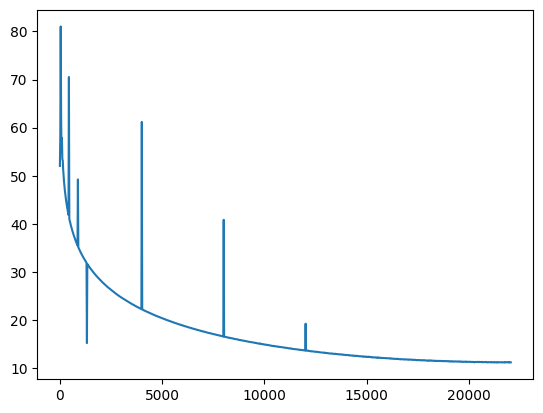

In [68]:
import matplotlib.pyplot as plt
from scipy.io import wavfile



sr, y = wavfile.read(audio_file)
y = y[:, 0]
pos = 0
time_window = 0.05  # 50ms window
sample_window = int(sr * time_window)
start = max(0, pos - sample_window // 2)
end = min(len(y), start + sample_window)

selected_samples = y[start:end]

# Berechnung der Fourier-Transformierten
N = len(selected_samples)
yf = np.fft.fft(selected_samples)
xf = np.linspace(0.0, sr / 2.0, N // 2)
magnitude = 2.0 / N * np.abs(yf[: N // 2])
magnitude_db = 20 * np.log10(magnitude)
freq_magn = {xf[i]: magnitude_db[i] for i in range(N // 2)}
max_magnitudes = np.sort(magnitude_db)[-12:]
max_indices = np.argsort(magnitude_db)[-12:]
for i in range(12):
    print(
        f"Frequency: {xf[max_indices[i]]:.2f} Hz, Magnitude: {max_magnitudes[i]:.2f} dB"
    )
plt.plot(xf, magnitude_db)


In [59]:
freq_magn

{0.0: 52.042873816302915,
 20.02724795640327: 58.356015228860336,
 40.05449591280654: 81.02354864357599,
 60.0817438692098: 62.31807653194946,
 80.10899182561307: 54.7453345592687,
 100.13623978201635: 57.830509576827126,
 120.1634877384196: 53.44456102549919,
 140.19073569482288: 53.195133308724884,
 160.21798365122615: 51.33317795354752,
 180.24523160762942: 49.98653749276145,
 200.2724795640327: 48.86996254353004,
 220.29972752043597: 47.90431711946647,
 240.3269754768392: 47.048537194468985,
 260.3542234332425: 46.27790821080221,
 280.38147138964575: 45.577501401231864,
 300.40871934604905: 44.93149593073886,
 320.4359673024523: 44.333206476259676,
 340.46321525885554: 43.77591423475287,
 360.49046321525884: 43.259073348490375,
 380.5177111716621: 42.76375181170205,
 400.5449591280654: 42.299919240189546,
 420.57220708446863: 41.86116557766907,
 440.59945504087193: 70.52246895676262,
 460.6267029972752: 41.04553949284571,
 480.6539509536784: 40.666042915099496,
 500.6811989100817: 